In [ ]:
import torch

from fastai.text.all import *
from fastai.basics import *

from reformer_fastai.reformer import ReformerLM, ReversibleLM
from reformer_fastai.transformer import TransformerLM

## Memory utils

In [ ]:
def _get_gpu_mem(synchronize=True, empty_cache=True):
    return torch.cuda.memory_allocated(), torch.cuda.memory_reserved()


def _generate_mem_hook(handle_ref, mem, idx, hook_type, exp):
    def hook(self, *args):
        if len(mem) == 0 or mem[-1]["exp"] != exp:
            call_idx = 0
        else:
            call_idx = mem[-1]["call_idx"] + 1

        mem_all, mem_cached = _get_gpu_mem()
        torch.cuda.synchronize()
        mem.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(self).__name__,
            'exp': exp,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_cached': mem_cached,
        })

    return hook


def _add_memory_hooks(idx, mod, mem_log, exp, hr):
    h = mod.register_forward_pre_hook(_generate_mem_hook(hr, mem_log, idx, 'pre', exp))
    hr.append(h)

    h = mod.register_forward_hook(_generate_mem_hook(hr, mem_log, idx, 'fwd', exp))
    hr.append(h)

    h = mod.register_backward_hook(_generate_mem_hook(hr, mem_log, idx, 'bwd', exp))
    hr.append(h)


def log_mem(model, inp, mem_log=None, exp=None):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        out = model(inp)
        loss = out.sum()
        loss.backward()
    finally:
        [h.remove() for h in hr]

        return mem_log


## baseline

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randint(256, (bs, sl)).cuda()

In [ ]:
torch.cuda.memory_allocated()

4096

In [ ]:
model = TransformerLM(256, d, n_layers=2).cuda()

In [ ]:
modules = [model.emb] + [m for m in model.encoder.layers] + [model.proj]
len(modules)

4

In [ ]:
mem_log = []
hr = []
for idx, module in enumerate(modules):
    _add_memory_hooks(idx, module, mem_log, 'baseline', hr)

In [ ]:
out = model(x)
loss = out.sum()
loss.backward()

In [ ]:
[h.remove() for h in hr];

In [ ]:
df = pd.DataFrame(mem_log)
df

,layer_idx,call_idx,layer_type,exp,hook_type,mem_all,mem_cached
0,0,0,TransformerEmbedding,baseline,pre,3123712,12582912
1,0,1,TransformerEmbedding,baseline,fwd,3288576,12582912
2,1,2,TransformerEncoderBlock,baseline,pre,3288576,12582912
3,1,3,TransformerEncoderBlock,baseline,fwd,12798464,33554432
4,2,4,TransformerEncoderBlock,baseline,pre,12798464,33554432
5,2,5,TransformerEncoderBlock,baseline,fwd,22308352,33554432
6,3,6,Linear,baseline,pre,22308352,33554432
7,3,7,Linear,baseline,fwd,22832640,33554432
8,3,8,Linear,baseline,bwd,20313088,33554432
9,2,9,TransformerEncoderBlock,baseline,bwd,20510720,33554432


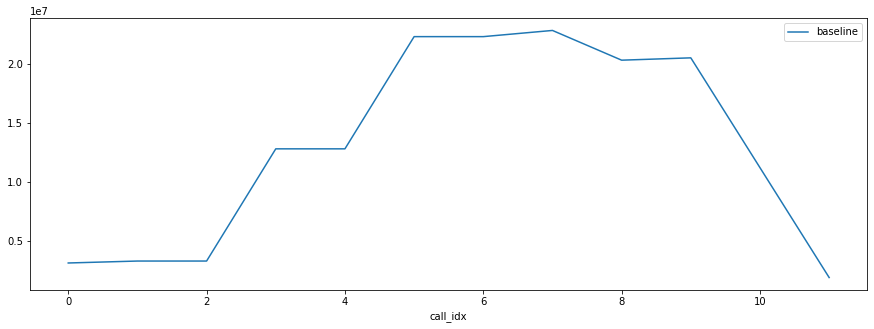

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot = df.plot(ax=ax, x='call_idx', y='mem_all', label='baseline')

In [ ]:
del x, model, modules
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

1720832

## revlayers

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randint(256, (bs, sl)).cuda()

In [ ]:
torch.cuda.memory_allocated()

1724928

In [ ]:
model = ReformerLM(256, d, n_layers=2).cuda()

In [ ]:
modules = [model.emb] + [m for m in model.encoder.layers.blocks] + [model.proj]
len(modules)

4

In [ ]:
mem_log = []
hr = []
for idx, module in enumerate(modules):
    _add_memory_hooks(idx, module, mem_log, 'revlayers', hr)

In [ ]:
out = model(x)
loss = out.sum()
loss.backward()

In [ ]:
[h.remove() for h in hr];

In [ ]:
df_rev = pd.DataFrame(mem_log)

In [ ]:
df_rev

,layer_idx,call_idx,layer_type,exp,hook_type,mem_all,mem_cached
0,0,0,TransformerEmbedding,revlayers,pre,2322944,8388608
1,0,1,TransformerEmbedding,revlayers,fwd,2455040,8388608
2,1,2,ReversibleBlock,revlayers,pre,2717184,8388608
3,1,3,ReversibleBlock,revlayers,fwd,2979328,29360128
4,2,4,ReversibleBlock,revlayers,pre,2979328,29360128
5,2,5,ReversibleBlock,revlayers,fwd,3241472,29360128
6,3,6,Linear,revlayers,pre,2717184,29360128
7,3,7,Linear,revlayers,fwd,3241472,29360128
8,3,8,Linear,revlayers,bwd,1522688,29360128
9,0,9,TransformerEmbedding,revlayers,bwd,2021376,29360128


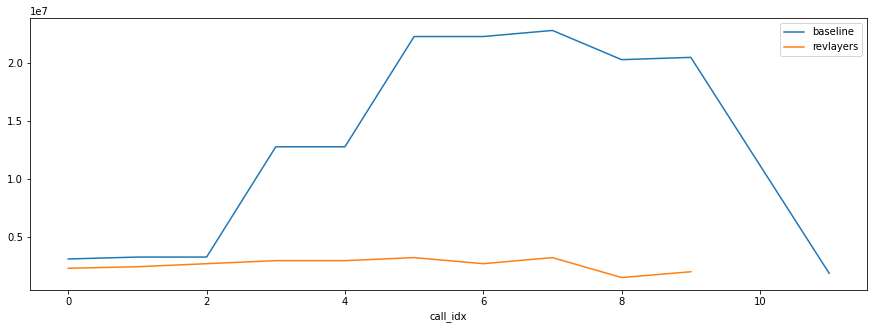

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot = df.plot(ax=ax, x='call_idx', y='mem_all', label='baseline')
plot = df_rev.plot(ax=ax, x='call_idx', y='mem_all', label='revlayers')

In [ ]:
del x, model, modules
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

1982976

## Learner patch

Note on `register_backward_hook`:

> The current implementation will not have the presented behavior for complex Module that perform many operations. In some failure cases, grad_input and grad_output will only contain the gradients for a subset of the inputs and outputs. For such Module, you should use [torch.Tensor.register_hook()](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook) directly on a specific input or output to get the required gradients.


In [ ]:
# class MemHook(Hook):
#     "Create a 'pre', 'fwd' or 'bwd' memory hook on `m`."
#     def __init__(self, m, hook_type, idx, call_idx, experiment=None):
#         store_attr('hook_type, idx, call_idx, experiment')
#         f = {
#             'pre':m.register_forward_pre_hook,
#             'fwd':m.register_forward_hook,
#             'bwd':m.register_backward_hook,
#         }
#         self.hook = f[hook_type](self.hook_fn)
#         self.stored,self.removed = None,False

#     def hook_fn(self, module, *args):
#         "Stores module description and memory stats"
#         if len(mem) == 0: call_idx = 0
#         else: call_idx = self.stored[-1]["call_idx"] + 1
#         inp_shape = args[0][0].shape
#         out_shape = args[1][0].shape if len(args)>1 else None
#         mem_all, mem_res = self._get_mem_stats()
#         self.stored = {
#             'layer_idx': self.idx,
#             'call_idx': call_idx,
#             'layer_type': type(module).__name__,
#             'experiment': self.experiment,
#             'hook_type': self.hook_type,
#             'mem_all': mem_all,
#             'mem_reserved': mem_res,
#             'input_shape': inp_shape,
#             'output_shape': out_shape,
#         }
    
#     @staticmethod
#     def _get_mem_stats():
#         "Supports only cuda for now"
#         torch.cuda.synchronize()
#         return torch.cuda.memory_allocated(), torch.cuda.memory_reserved()


In [ ]:
# class MemHooks(Hooks):
#     "Creates hooks wich grab memory stats"
#     def __init__(self, modules):
#         self.hooks = []
#         for i, m in enumerate(modules): self.register_memory_hooks(m, i)

#     def register_memory_hooks(self, m, i):
#         for hook_type in ['pre', 'fwd', 'bwd']:
#             self.hooks.append(MemHook(m, hook_type, i, len(self.hooks)))


In [ ]:
#dummy datasets
train = [(torch.randint(256, (64,)), torch.randint(256, (64,))) for _ in range(800)]
valid = [(torch.randint(256, (64,)), torch.randint(256, (64,))) for _ in range(200)]

dls = DataLoaders.from_dsets(train, valid, bs=16, device='cuda')

xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 64]), torch.Size([16, 64]))

### V0

In [ ]:
from fastai.callback.all import Hooks

def _generate_mem_hook(mem_log, idx, hook_type, experiment):
    def hook(module, *args):
        inp_shape = args[0][0].shape
        out_shape = args[1][0].shape if len(args)>1 else None
        if len(mem_log) == 0: call_idx = 0
        else: call_idx = mem_log[-1]["call_idx"] + 1
        mem_all = torch.cuda.memory_allocated()
        mem_reserved = torch.cuda.memory_reserved()
        torch.cuda.synchronize()
        mem_log.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(module).__name__,
            'experiment': experiment,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_reservd': mem_reserved,
            'input_shape': inp_shape,
            'output_shape': out_shape,
        })
    return hook

class MemHooks(Hooks):
    "Creates hooks for logging memory stats"
    def __init__(self, modules, name=None):
        self.hooks = []
        self.mem_log = []
        for i, m in enumerate(modules): self.register_memory_hooks(m, i, name=name)

    def register_memory_hooks(self, m, i, name=None):
        fs = {'pre':m.register_forward_pre_hook,
              'fwd':m.register_forward_hook,
              'bwd':m.register_backward_hook}
        for hook_type in ['pre', 'fwd', 'bwd']:
            self.hooks.append(fs[hook_type](_generate_mem_hook(self.mem_log, i, hook_type, name)))

In [ ]:
def profile_memory(learn, plot=True):
    with MemHooks(flatten_model(learn.model), type(learn.model).__name__) as h:
        xb, yb = learn.dls.one_batch()
        self.model.to(self.dls.device)
        out = learn.model(xb)
        loss = learn.loss_func(out, yb)
        loss.backward()
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    if plot:
        plt.plot(mem_log['call_idx'], mem_log['mem_all'])
    return mem_log

In [ ]:
@patch
def profile_memory(self:Learner, modules=None, plot=True):
    modules = ifnone(modules, flatten_model(self.model))
    with MemHooks(modules, name=type(self.model).__name__) as h:
        xb, yb = self.dls.one_batch()
        self.model.to(self.dls.device)
        out = self.model(xb)
        loss = self.loss_func(out, yb)
        loss.backward()
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    if plot:
        plt.plot(mem_log['call_idx'], mem_log['mem_all'], label='mem_profile')
    return mem_log

In [ ]:
learn = Learner(dls, TransformerLM(256, 64, n_layers=2), loss_func=CrossEntropyLossFlat())

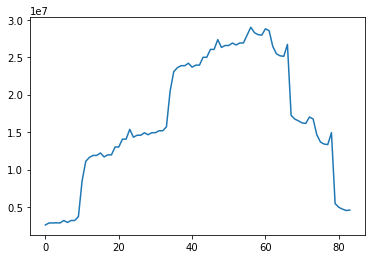

In [ ]:
mem_log = learn.profile_memory()

In [ ]:
del learn
torch.cuda.empty_cache()

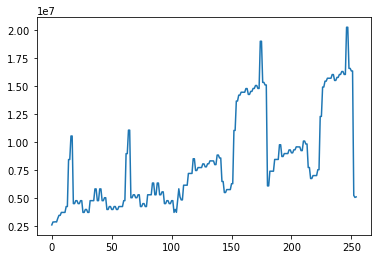

In [ ]:
learn = Learner(dls, ReversibleLM(256, 64, n_layers=2), loss_func=CrossEntropyLossFlat())
revmem_log = learn.profile_memory()

In [ ]:
revmem_log.head()

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,ReversibleLM,pre,2614784,12582912,"(16, 64)",None
1,0,1,Embedding,ReversibleLM,fwd,2876928,12582912,"(16, 64)","(64, 64)"
2,2,2,Embedding,ReversibleLM,pre,2877440,12582912,"(64,)",None
3,2,3,Embedding,ReversibleLM,fwd,2893824,12582912,"(64,)","(64,)"
4,1,4,Dropout,ReversibleLM,pre,2877440,12582912,"(16, 64, 64)",None


### V1

Is this good enough for genral purpose mem profile?

In [ ]:
class MemProfileCallback(Callback):
    "Cancels batch after backward to avoid opt.step()"
    def before_batch(self):
        # learn._split(learn.dls.one_batch())
        # self.model.to(self.dls.device)
        self.model.train()
        self.learn.training = True
    def after_backward(self):
        print('Batch canceled')
        raise CancelBatchException

In [ ]:
# with MemHooks(flatten_model(learn.model)) as h:
#     xb, yb = learn.dls.one_batch()
#     out = learn.model(xb)
#     loss = learn.loss_func(out, yb)
#     loss.backward()
#     mem_log = h.stored
# mem_data = pd.DataFrame(mem_log)
# mem_data.head()

In [ ]:
learn = Learner(dls, TransformerLM(256, 64, n_layers=2), loss_func=CrossEntropyLossFlat())

In [ ]:
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [ ]:
def _with_events(self, f, event_type, ex, final=noop):
    try:       self(f'before_{event_type}')       ;f()
    except ex: self(f'after_cancel_{event_type}')
    finally:   self(f'after_{event_type}')        ;final()

def all_batches(self):
    self.n_iter = len(self.dl)
    for o in enumerate(self.dl): self.one_batch(*o)

def _do_one_batch(self):
    self.pred = self.model(*self.xb)
    self('after_pred')
    if len(self.yb): self.loss = self.loss_func(self.pred, *self.yb)
    self('after_loss')
    if not self.training or not len(self.yb): return
    self('before_backward')
    self._backward()
    self('after_backward')
    self._step()
    self('after_step')
    self.opt.zero_grad()

def one_batch(self, i, b):
    self.iter = i
    self._split(b)
    self._with_events(self._do_one_batch, 'batch', CancelBatchException)

In [ ]:
# learn._split(learn.dls.one_batch())
# with learn.added_cbs(MemProfileCallback()), learn.no_logging():
#     try: learn._do_one_batch()
#     except CancelBatchException:
#         for p in learn.model.parameters(): p.grad=None

In [ ]:
def profile_memory(learn, plot=True):
    with MemHooks(flatten_model(learn.model), type(learn.model).__name__) as h:
        learn._split(learn.dls.one_batch())
        learn.model.to(learn.dls.device)
        
        with learn.added_cbs(MemProfileCallback()), learn.no_logging():
            learn('before_batch')
            try: learn._do_one_batch()
            except CancelBatchException:
                for p in learn.model.parameters(): p.grad=None
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    if plot:
        plt.plot(mem_log['call_idx'], mem_log['mem_all'])
    return mem_log

Batch canceled


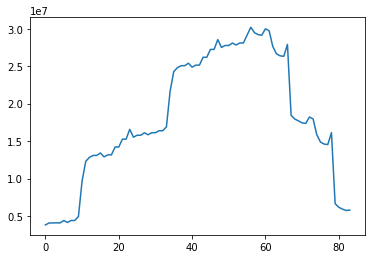

In [ ]:
mem_log = profile_memory(learn)

In [ ]:
mem_log.head()

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,TransformerLM,pre,3811840,33554432,"(16, 64)",None
1,0,1,Embedding,TransformerLM,fwd,4073984,33554432,"(16, 64)","(64, 64)"
2,2,2,Embedding,TransformerLM,pre,4074496,33554432,"(64,)",None
3,2,3,Embedding,TransformerLM,fwd,4090880,33554432,"(64,)","(64,)"
4,1,4,Dropout,TransformerLM,pre,4074496,33554432,"(16, 64, 64)",None


In [ ]:
@patch
def profile_memory(self:Learner, plot=True):
    with MemHooks(flatten_model(self.model), type(self.model).__name__) as h:
        self._split(self.dls.one_batch())
        self.model.to(self.dls.device)
        with self.added_cbs(MemProfileCallback()), self.no_logging():
            self('before_batch')
            try: self._do_one_batch()
            except CancelBatchException:
                for p in self.model.parameters(): p.grad=None
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    if plot:
        plt.plot(mem_log['call_idx'], mem_log['mem_all'])
    return mem_log

Batch canceled


,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,TransformerLM,pre,5475328,41943040,"(16, 64)",None
1,0,1,Embedding,TransformerLM,fwd,5737472,41943040,"(16, 64)","(64, 64)"
2,2,2,Embedding,TransformerLM,pre,5737984,41943040,"(64,)",None
3,2,3,Embedding,TransformerLM,fwd,5754368,41943040,"(64,)","(64,)"
4,1,4,Dropout,TransformerLM,pre,5737984,41943040,"(16, 64, 64)",None
...,...,...,...,...,...,...,...,...,...
79,4,79,Linear,TransformerLM,bwd,8319488,44040192,"(1024, 128)","(16, 64, 128)"
80,3,80,Linear,TransformerLM,bwd,7827968,44040192,"(1024, 64)","(16, 64, 64)"
81,1,81,Dropout,TransformerLM,bwd,7582208,44040192,"(16, 64, 64)","(16, 64, 64)"
82,2,82,Embedding,TransformerLM,bwd,7401984,44040192,"(512, 64)","(64, 64)"


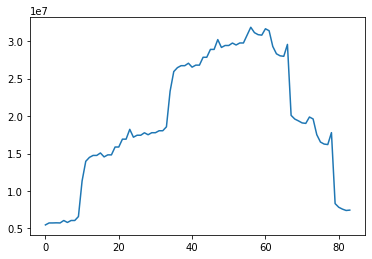

In [ ]:
learn = Learner(dls, TransformerLM(256, 64, n_layers=2), loss_func=CrossEntropyLossFlat())
learn.profile_memory()

Batch canceled


,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,ReversibleLM,pre,7139840,44040192,"(16, 64)",None
1,0,1,Embedding,ReversibleLM,fwd,7401984,44040192,"(16, 64)","(64, 64)"
2,2,2,Embedding,ReversibleLM,pre,7402496,44040192,"(64,)",None
3,2,3,Embedding,ReversibleLM,fwd,7418880,44040192,"(64,)","(64,)"
4,1,4,Dropout,ReversibleLM,pre,7402496,44040192,"(16, 64, 64)",None
...,...,...,...,...,...,...,...,...,...
250,4,250,Linear,ReversibleLM,bwd,20872192,44040192,"(1024, 64)","(16, 64, 64)"
251,28,251,Linear,ReversibleLM,bwd,20872192,44040192,"(1024, 64)","(16, 64, 64)"
252,1,252,Dropout,ReversibleLM,bwd,9772032,44040192,"(16, 64, 64)","(16, 64, 64)"
253,2,253,Embedding,ReversibleLM,bwd,9591808,44040192,"(512, 64)","(64, 64)"


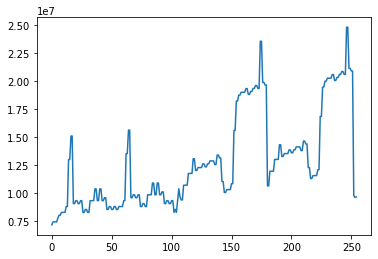

In [ ]:
learn = Learner(dls, ReversibleLM(256, 64, n_layers=2), loss_func=CrossEntropyLossFlat())
mem_log = learn.profile_memory()

Batch canceled


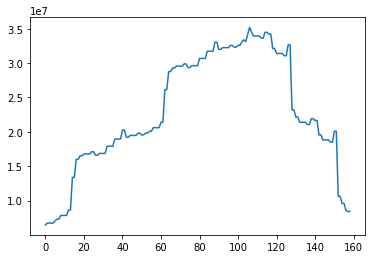

In [ ]:
learn = Learner(dls, ReversibleLM(256, 64, n_layers=2, rev_thres=1024), loss_func=CrossEntropyLossFlat())
mem_log = learn.profile_memory()